In [1]:
import numpy
import pandas as pd
import tqdm

https://www.cheminformania.com/ligand-docking-with-smina/

```python
fetch 5WIU
remove resn HOH
h_add elem O or elem N
select 1OYT-FSN, resn FSN #Create a selection called 1OYT-FSN from the ligand
select 1OYT-receptor, 1OYT and not 1OYT-FSN #Select all that is not the ligand
save 1OYT-FSN.pdb, 1OYT-FSN
save 1OYT-receptor.pdb, 1OYT-receptor
```


```
obabel 1OYT-receptor.pdb -xr -O 1OYT-receptor.pdbqt
obabel 1OYT-FSN.pdb -O 1OYT-FSN.pdbqt

```

```
smina.static -r 1OYT-receptor.pdbqt -l 1OYT-FSN.pdbqt --autobox_ligand 1OYT-FSN.pdbqt --autobox_add 8 --exhaustiveness 16 -o 1OYT-redock.pdbqt
```

In [15]:
df = pd.read_csv('https://gist.githubusercontent.com/ljmartin/82f0dfe9f58e584a3e5186afe6e75973/raw/4315cb08931628f03781546da46c0b98875c453b/41586_2019_917_MOESM4_ESM.csv')
df = df['SMILES'][:5]

In [4]:
#convert ligand:
!obabel 5WIU-CAC.pdb -O 5WIU-CAC.pdbqt

#convert receptor
!obabel 5WIU-receptor.pdb -xr -O 5WIU-receptor.pdbqt

1 molecule converted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is 5WIU-receptor.pdb)

1 molecule converted


In [18]:
df

0    Cc1ccc(C[C@@H](CO)N[C@@H](C)CCc2ccccc2[N+](=O)...
1    C[C@H](C(=O)Nc1cc([N+](=O)[O-])ccc1Cl)N(C)C[C@...
2      C[C@@H](NC[C@](C)(O)c1ccccc1)c1cn(-c2ccccc2)nn1
3    C[C@H](Nc1cc(-n2cccn2)nc(N)n1)[C@H](c1ccccc1)N...
4          COC(=O)C[C@H]1CSCCN1Cc1cn(-c2cccc(C)c2)nc1C
Name: SMILES, dtype: object

In [ ]:

#./smina.static -r 5WIU-receptor.pdbqt --quiet -l nam.pdbqt --cpu 2 --autobox_ligand 5WIU-CAC.pdbqt --autobox_add 8 --log hi.log --exhaustiveness 4 >/dev/null
    
for count, smi in tqdm.tqdm_notebook(enumerate(df)):
    #convert the ligand:
    !obabel -:"$smi" --gen3d ---errorlevel 1 --partial_charges gasteiger -O nam.pdbqt >/dev/null
    
    #perform docking:    
    !./smina.static -r 5WIU-receptor.pdbqt --quiet -l nam.pdbqt --cpu 2 --autobox_ligand 5WIU-CAC.pdbqt --autobox_add 8 --log hi.log --exhaustiveness 4 --num_modes 1 -o "$count".pdbqt
    
    #save as a pdb:
    !obabel -ipdbqt "$count".pdbqt -O "$count".pdb
    

<ipython-input-19-a59e749c6ba0>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for count, smi in tqdm.tqdm_notebook(enumerate(df)):


1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 9.27113
Loop time 10.8096
1 molecule converted
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 7.67843
Loop time 9.54028
1 molecule converted
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
*************************************

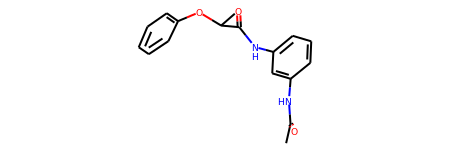

In [10]:
from rdkit import Chem
Chem.MolFromPDBFile('0.pdb')